# Daten einlesen und Pipeline definieren

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

def r2(actual: np.ndarray, predicted: np.ndarray):
    """ R2 Score """
    return r2_score(actual, predicted)

def adjr2(actual: np.ndarray, predicted: np.ndarray, rowcount: int, featurecount: int):
    """ Adjusted R2 Score """
    return 1-(1-r2(actual,predicted))*(rowcount-1)/(rowcount-featurecount)

def add_features(df):
    df['Jahr'] = df['Datum'].dt.year
    df['Monat'] = df['Datum'].dt.month
    df['Wochentag'] = df['Datum'].dt.weekday
    df['Kalenderwoche'] = df['Datum'].dt.isocalendar().week
    df['Tag_im_Jahr'] = df['Datum'].dt.dayofyear
    df['Ist_Wochenende'] = df['Wochentag'].isin([5, 6]).astype(int)
    df['Tag_im_Jahr_sin'] = np.sin(2 * np.pi * df['Tag_im_Jahr'] / 365)
    df['Tag_im_Jahr_cos'] = np.cos(2 * np.pi * df['Tag_im_Jahr'] / 365)
    df['Monat_sin'] = np.sin(2 * np.pi * df['Monat'] / 12)
    df['Monat_cos'] = np.cos(2 * np.pi * df['Monat'] / 12)
    df['Wochentag_sin'] = np.sin(2 * np.pi * df['Wochentag'] / 7)
    df['Wochentag_cos'] = np.cos(2 * np.pi * df['Wochentag'] / 7)
    return df

def preprocess_data(df):
    df['Datum'] = pd.to_datetime(df['Datum'])
    df = add_features(df)
    df['Wettercode'] = df['Wettercode'].astype(str)
    df['KielerWoche'] = df['KielerWoche'].fillna(False).astype('bool')
    return df

# Load datasets

# Basisdatenset
df1 = pd.read_csv('../umsatzdaten_gekuerzt.csv')
# Wetterdaten
df2 = pd.read_csv('../wetter.csv')
# Kielerwocher
df3 = pd.read_csv('../kiwo.csv')
# Feiertage, Brückentage, Ferien
df4 = pd.read_csv('../Feier_Bruecke_Ferien_bis2018.csv')
# Verbraucherpreisindex
df5 = pd.read_csv('../VPI.csv')
# Erzeugerpreisindex
df6 = pd.read_csv('../EPI.csv')
# Heimspiele Holstein Kiel
df7 = pd.read_csv('../Heimspiel_Holstein_Kiel_finle.csv')
# Kieler Umschlag (kleineres Fest in Kiel)
df8 = pd.read_csv('../Kieler_Umschlag_finale.csv')
# Schulferien Litauen
df9 = pd.read_csv('../Schulferien_Litauen_finale.csv')

# Merge datasets
df = df1.merge(df2, on='Datum', how='left')
df = df.merge(df3, on='Datum', how='left')
df = df.merge(df4, on='Datum', how='left')
df = df.merge(df5, on='Datum', how='left')
df = df.merge(df6, on='Datum', how='left')
df = df.merge(df7, on='Datum', how='left')
df = df.merge(df8, on='Datum', how='left')
df = df.merge(df9, on='Datum', how='left')


missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
# Preprocess data
df = preprocess_data(df)

# Define feature groups
numeric_features = ['Temperatur', 'Bewoelkung','HeimspielHK', 'KielerUmschlag', 'Windgeschwindigkeit', 'Tag_im_Jahr_sin', 'Tag_im_Jahr_cos', 'Monat_sin', 'Monat_cos', 'Wochentag_sin', 'Wochentag_cos', 'feiertag', 'KielerWoche', 'brueckentag', 'BW', 'BY', 'B', 'BB', 'HB', 'HH', 'HE', 'MV', 'NI', 'NW', 'RP', 'SL', 'SN', 'ST', 'SH', 'TH', 'VPI_brot_getreide', 'VPI_molkerei_ei', 'VPI_speiseoel_fett', 'VPI_Obst', 'VPI_zucker_suesses', 'EPI_teig', 'EPI_wasser', 'EPI_strom', 'EPI_fernwaerme', 'Herbstferien_LI', 'Weihnachtsferien_LI', 'Winterferien_LI', 'Fruehlingsferien_LI', 'Sommerferien_LI']
categorical_features = ['Warengruppe', 'Wettercode', 'Wochentag']



# Define ColumnTransformer
wettercode_categories = [str(i) for i in range(0, 100)] + ['Unbekannt']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), [feature for feature in numeric_features if feature != 'KielerWoche']),
        ('kielerwoche', SimpleImputer(strategy='constant', fill_value=0), ['KielerWoche']),
        ('wettercode', OneHotEncoder(categories=[wettercode_categories], handle_unknown='ignore'), ['Wettercode']),
        ('warengruppe', OneHotEncoder(handle_unknown='ignore'), ['Warengruppe']),
        ('wochentag', OneHotEncoder(handle_unknown='ignore'), ['Wochentag'])
    ],
    remainder='drop'
)
# Ensure 'KielerWoche' is int after preprocessing
df['KielerWoche'] = df['KielerWoche'].astype(int)


# Datenset analysieren & visualisieren

In [10]:

# Display basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9334 entries, 0 to 9333
Data columns (total 55 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   9334 non-null   int64         
 1   Datum                9334 non-null   datetime64[ns]
 2   Warengruppe          9334 non-null   int64         
 3   Umsatz               9334 non-null   float64       
 4   Bewoelkung           9264 non-null   float64       
 5   Temperatur           9318 non-null   float64       
 6   Windgeschwindigkeit  9318 non-null   float64       
 7   Wettercode           9334 non-null   object        
 8   KielerWoche          9334 non-null   int64         
 9   feiertag             9334 non-null   int64         
 10  brueckentag          9334 non-null   int64         
 11  BW                   9334 non-null   int64         
 12  BY                   9334 non-null   int64         
 13  B                    9334 non-nul

In [11]:

# Display summary statistics
df.describe()


,id,Warengruppe,Umsatz,Bewoelkung,Temperatur,Windgeschwindigkeit,KielerWoche,feiertag,brueckentag,BW,...,Wochentag,Kalenderwoche,Tag_im_Jahr,Ist_Wochenende,Tag_im_Jahr_sin,Tag_im_Jahr_cos,Monat_sin,Monat_cos,Wochentag_sin,Wochentag_cos
count,9.334000e+03,9334.000000,9334.000000,9264.000000,9318.000000,9318.000000,9334.000000,9334.000000,9334.000000,9334.000000,...,9334.000000,9334.0,9334.000000,9334.000000,9334.000000,9334.000000,9.334000e+03,9.334000e+03,9334.000000,9334.000000
mean,1.559311e+06,3.088172,206.749044,4.720747,12.028483,10.974780,0.023891,0.018320,0.006000,0.226270,...,3.000536,27.131241,187.077566,0.286908,-0.022203,0.005868,-2.367736e-02,9.238488e-03,0.001947,0.002179
std,1.512503e+05,1.489002,144.545189,2.646273,7.232829,4.131974,0.152718,0.134113,0.077228,0.418438,...,2.001044,15.107807,105.642747,0.452343,0.700193,0.713660,6.980723e-01,7.156509e-01,0.708564,0.705716
min,1.307011e+06,1.000000,7.051201,0.000000,-8.475000,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.0,2.000000,0.000000,-0.999991,-0.999963,-1.000000e+00,-1.000000e+00,-0.974928,-0.900969
25%,1.410123e+06,2.000000,96.897441,3.000000,6.237500,8.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,14.0,95.250000,0.000000,-0.710138,-0.720667,-5.000000e-01,-8.660254e-01,-0.781831,-0.900969
50%,1.601102e+06,3.000000,161.900831,6.000000,11.625000,10.000000,0.000000,0.000000,0.000000,0.000000,...,3.000000,28.0,190.000000,0.000000,-0.060213,0.021516,-2.449294e-16,6.123234e-17,0.000000,-0.222521
75%,1.704223e+06,4.000000,280.644663,7.000000,17.962500,13.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,40.0,280.000000,1.000000,0.680773,0.726608,5.000000e-01,8.660254e-01,0.781831,0.623490
max,1.807315e+06,6.000000,1879.461831,8.000000,31.437500,35.000000,1.000000,1.000000,1.000000,1.000000,...,6.000000,53.0,366.000000,1.000000,0.999991,1.000000,1.000000e+00,1.000000e+00,0.974928,1.000000


In [12]:

# Display the first few rows of the dataset
df.head()


,id,Datum,Warengruppe,Umsatz,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,KielerWoche,feiertag,...,Wochentag,Kalenderwoche,Tag_im_Jahr,Ist_Wochenende,Tag_im_Jahr_sin,Tag_im_Jahr_cos,Monat_sin,Monat_cos,Wochentag_sin,Wochentag_cos
0,1307011,2013-07-01,1,148.828353,6.0,17.8375,15.0,20.0,0,0,...,0,27,182,0,0.008607,-0.999963,-0.5,-0.866025,0.000000,1.000000
1,1307021,2013-07-02,1,159.793757,3.0,17.3125,10.0,nan,0,0,...,1,27,183,0,-0.008607,-0.999963,-0.5,-0.866025,0.781831,0.623490
2,1307031,2013-07-03,1,111.885594,7.0,21.0750,6.0,61.0,0,0,...,2,27,184,0,-0.025818,-0.999667,-0.5,-0.866025,0.974928,-0.222521
3,1307041,2013-07-04,1,168.864941,7.0,18.8500,7.0,20.0,0,0,...,3,27,185,0,-0.043022,-0.999074,-0.5,-0.866025,0.433884,-0.900969
4,1307051,2013-07-05,1,171.280754,5.0,19.9750,12.0,nan,0,0,...,4,27,186,0,-0.060213,-0.998186,-0.5,-0.866025,-0.433884,-0.900969


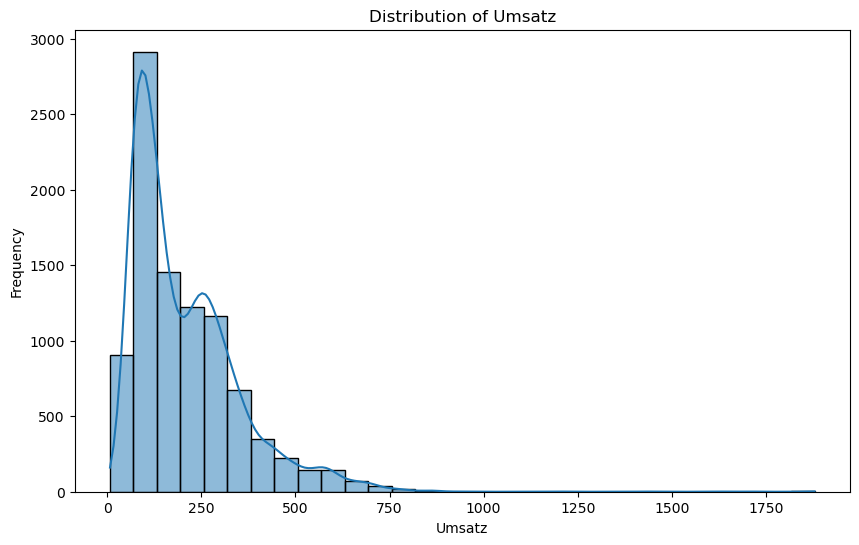

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the target variable 'Umsatz'
plt.figure(figsize=(10, 6))
sns.histplot(df['Umsatz'], bins=30, kde=True)
plt.title('Distribution of Umsatz')
plt.xlabel('Umsatz')
plt.ylabel('Frequency')
plt.show()

In [17]:
# Calculate correlation of 'Umsatz' with other features
correlation_with_umsatz = df.corr()['Umsatz'].drop('Umsatz').sort_values(ascending=False)
correlation_with_umsatz


/var/folders/tv/qpxdljv13vd6jxppkbwll56w0000gn/T/ipykernel_39555/796099385.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_with_umsatz = df.corr()['Umsatz'].drop('Umsatz').sort_values(ascending=False)


Sommerferien_LI        0.231082
Temperatur             0.222935
NW                     0.193754
BB                     0.185120
B                      0.183774
TH                     0.183471
RP                     0.183448
MV                     0.180764
SH                     0.175640
ST                     0.171530
SL                     0.166413
HE                     0.164913
SN                     0.163594
NI                     0.163162
Ist_Wochenende         0.163097
HB                     0.162725
BW                     0.155330
HH                     0.148356
Wochentag              0.136199
BY                     0.131208
EPI_fernwaerme         0.095317
KielerWoche            0.058244
feiertag               0.050638
HeimspielHK            0.042073
Weihnachtsferien_LI    0.030706
Wochentag_cos          0.024867
brueckentag            0.018589
Tag_im_Jahr            0.015356
Windgeschwindigkeit    0.014705
Monat                  0.013889
EPI_teig               0.006618
Fruehlin